In [1]:
import csv
from collections import namedtuple
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import utils.train as train_util


In [2]:
Record = namedtuple('Record', ('user_id, game_name, play_time'))

def load_records(path: str) -> List[Record]:
    records: List[Record] = []
    with open(path, encoding='utf-8') as fp:
        reader = csv.reader(fp)
        for (uid, game, action, time, _) in reader:
            uid = int(uid)
            time = float(time)
            if action == 'purchase':
                records.append(Record(uid, game, 0.0))
            elif records[-1].game_name == game:
                records.pop()
                records.append(Record(uid, game, time))
    return records

train_records = load_records('./data/steam-video-games/steam-200k-train.csv')
test_records = load_records('./data/steam-video-games/steam-200k-test.csv')

print(f'{len(train_records)} training records')
print(f'{len(test_records)} testing records')


97511 training records
32000 testing records


In [3]:
UNK_GAME = '<unk>'
UNK_ID = 0

def build_game_set(records: List[Record]) -> Tuple[Dict[str, int], List[str]]:
    assert UNK_ID == 0
    game2index = {UNK_GAME: UNK_ID}
    index2game = [UNK_GAME]
    for record in records:
        game = record.game_name
        if game in game2index:
            continue
        game2index[game] = len(index2game)
        index2game.append(game)
    return game2index, index2game


game2index, index2game = build_game_set(train_records)

print(f'{len(game2index)} games')


4870 games


In [4]:
def generate_dataset(reocrds: List[Record], game2index: Dict[str, int], context_size: int = 3) -> Dataset:
    user_id = -1
    buffer = []
    inputs = []
    targets = []
    for record in reocrds:
        if record.user_id != user_id:
            user_id = record.user_id
            buffer.clear()
        buffer.append(game2index.get(record.game_name, 0))
        if len(buffer) > context_size:
            inputs.append(buffer[:-1])
            targets.append(buffer[-1])
            buffer.pop(0)
    return TensorDataset(
        torch.LongTensor(inputs),
        torch.LongTensor(targets),
    )


train_dataset = generate_dataset(train_records, game2index)
test_dataset = generate_dataset(test_records, game2index)


In [5]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [6]:
batch_x, batch_y = next(iter(train_loader))
for i in range(4):
    print([index2game[game_id] for game_id in batch_x[i]], ' -> ', index2game[batch_y[i]])

['FreeStyle2 Street Basketball', 'Archeblade', 'Fallen Earth']  ->  GunZ 2 The Second Duel
['Far Cry 3', 'Deathmatch Classic', 'Ricochet']  ->  Serious Sam The Random Encounter
['Counter-Strike Source', 'Counter-Strike Global Offensive', 'Dota 2']  ->  Dark Souls Prepare to Die Edition
['Just Cause 2', 'H1Z1', 'The Elder Scrolls V Skyrim']  ->  Company of Heroes 2


In [7]:
class CBOG(nn.Module):
    def __init__(self, num_games: int, embedding_size: int):
        super().__init__()
        self.embeddings = nn.Embedding(num_games, embedding_size, padding_idx=UNK_ID)
        self.linear = nn.Linear(embedding_size, num_games)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds_sum = embeds.sum(dim=1)
        out = self.linear(embeds_sum)
        return out

In [8]:
torch.manual_seed(42)

model = CBOG(num_games=len(game2index), embedding_size=16).cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Epoch: 1/25 @ 2021-08-11 22:50:24.969018
310/310 [==============================] - 2s 7ms/step - loss: 8.501 - accuracy: 0.011 - val_loss: 8.184 - val_accuracy: 0.028
Epoch: 2/25 @ 2021-08-11 22:50:27.177212
310/310 [==============================] - 2s 6ms/step - loss: 7.812 - accuracy: 0.041 - val_loss: 7.676 - val_accuracy: 0.044
Epoch: 3/25 @ 2021-08-11 22:50:28.921215
310/310 [==============================] - 2s 6ms/step - loss: 7.281 - accuracy: 0.059 - val_loss: 7.303 - val_accuracy: 0.057
Epoch: 4/25 @ 2021-08-11 22:50:30.663216
310/310 [==============================] - 2s 6ms/step - loss: 6.908 - accuracy: 0.073 - val_loss: 7.067 - val_accuracy: 0.069
Epoch: 5/25 @ 2021-08-11 22:50:32.476225
310/310 [==============================] - 2s 6ms/step - loss: 6.661 - accuracy: 0.083 - val_loss: 6.920 - val_accuracy: 0.075
Epoch: 6/25 @ 2021-08-11 22:50:34.289225
310/310 [==============================] - 2s 6ms/step - loss: 6.485 - accuracy: 0.092 - val_loss: 6.821 - val_accuracy

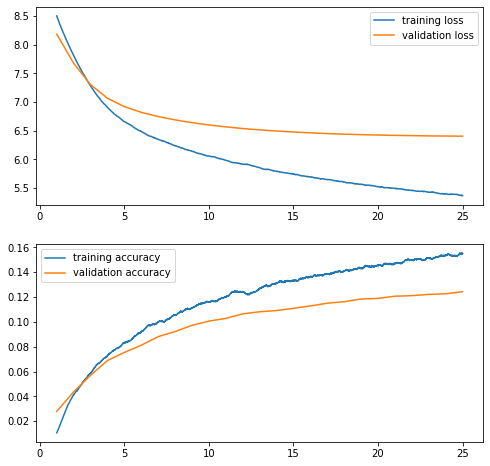

In [9]:
history = train_util.train_model(
    model, loss_func, optimizer,
    train_loader, test_loader,
    epochs=25
)

train_util.plot_history(history)

In [10]:
embedding_weights = model.embeddings.weight.cpu().detach().numpy()

In [11]:
from collections import Counter

top_games = [g for g, _ in Counter(r.game_name for r in train_records).most_common(500)]
top_game_ids = [game2index[g] for g in top_games]


In [12]:
import csv
import string

PERMITTED_CHARS = string.ascii_lowercase + string.digits + ' '


def clean_game_name(game_name: str) -> str:
    game_name = game_name.lower()
    game_name = ''.join(c for c in game_name if c in PERMITTED_CHARS)
    return ' '.join(game_name.split())


game_genres = {}
with open('./data/steam-store-games/steam.csv', encoding='utf-8') as fp:
    reader = csv.reader(fp)
    for row in reader:
        (
            appid, name, release_date, english, developer, publisher, platforms, required_age, categories, genres, steamspy_tags,
            achievements, positive_ratings, negative_ratings, average_playtime, median_playtime, owners, price
        ) = row
        tags = set()
        tags.add(release_date.split('-')[0])
        tags.add(developer)
        tags.update(categories.split(';'))
        tags.update(genres.split(';'))
        tags.update(steamspy_tags.split(';'))
        tags.add('free' if price == '0.0' else 'paid')
        game_genres[clean_game_name(name)] = ';'.join(tags)


game_metadata = [f"{g} ({game_genres.get(clean_game_name(g))})" for g in index2game]


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding_weights)

free_game_indexes = []
paid_game_indexes = []

for i, g in enumerate(game_metadata):
    if "free" in g:
        free_game_indexes.append(i)
    else:
        paid_game_indexes.append(i)

plt.figure(figsize=(8, 8))
plt.scatter(embedding_pca[paid_game_indexes][:,0], embedding_pca[paid_game_indexes][:,1])
plt.scatter(embedding_pca[free_game_indexes][:,0], embedding_pca[free_game_indexes][:,1])
plt.show()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.add_embedding(embedding_weights[top_game_ids], [game_metadata[i] for i in top_game_ids])
writer.close()


In [ ]:
clean_game_to_index = {}

for i, game in enumerate(index2game):
    clean_game_to_index[clean_game_name(game)] = i

In [ ]:
import numpy as np


def recommender(query_games):
    query_ids = [clean_game_to_index.get(clean_game_name(g), UNK_ID) for g in query_games]
    model.eval()
    with torch.no_grad():
        scores = model(torch.LongTensor([query_ids]).cuda()).detach().cpu()[0].numpy()
    sorted_indexes = np.argsort(scores)[::-1]
    games = []
    for i in sorted_indexes:
        games.append(index2game[i])
    return games


In [ ]:
recommender(["Grand Theft Auto V"])[:10]


['Left 4 Dead 2',
 'Dota 2',
 "Garry's Mod",
 'Team Fortress 2',
 'The Elder Scrolls V Skyrim',
 'Borderlands 2',
 'BioShock',
 'Fallout New Vegas',
 'Counter-Strike',
 'Unturned']

In [ ]:
recommender(["Counter-Strike"])[:10]

['Counter-Strike Condition Zero',
 'Counter-Strike Source',
 'Day of Defeat',
 'Counter-Strike Condition Zero Deleted Scenes',
 'Deathmatch Classic',
 'Team Fortress Classic',
 'Half-Life',
 'Team Fortress 2',
 'Portal',
 'Unturned']

In [ ]:
recommender(["Half-Life 2"])[:10]

['Half-Life 2 Deathmatch',
 'Half-Life 2 Episode One',
 'Half-Life 2 Episode Two',
 'Half-Life 2',
 'Portal',
 'Half-Life 2 Lost Coast',
 'Grand Theft Auto Episodes from Liberty City',
 'Half-Life',
 'Grand Theft Auto San Andreas',
 'Alien Swarm']

In [ ]:
recommender([
    "Grand Theft Auto V",
    "Insurgency",
    "Left 4 Dead 2"
])[:10]

['Team Fortress 2',
 'Left 4 Dead 2',
 'Dota 2',
 'Borderlands 2',
 'Portal 2',
 'Counter-Strike Global Offensive',
 "Garry's Mod",
 'The Elder Scrolls V Skyrim',
 'PAYDAY 2',
 'Counter-Strike Source']